In [35]:
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
results_dir = os.path.abspath('.')

In [7]:
os.chdir(results_dir)
experiment = 'E_Coli_ART_Illumina'
os.chdir(experiment)

results_file_re = re.compile(r'K(\d+)W(\d+)D(\d+)T(\d+).results')
results_files = [filename for filename in os.listdir() if results_file_re.match(filename)]

Ks = set()
Ws = set()
Ds = set()
Ts = set()

for filename in results_files:
    match = results_file_re.match(filename)
    
    Ks.add(int(match.group(1)))
    Ws.add(int(match.group(2)))
    Ds.add(int(match.group(3)))
    Ts.add(int(match.group(4)))

f'{Ks = }; {Ws = }; {Ds = }; {Ts = }'

'Ks = {31}; Ws = {15000000, 12500000, 17500000, 7500000, 10000000, 5000000, 20000000}; Ds = {8}; Ts = {40}'

In [24]:
def reverse_complement(sequence: str):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    complement_sequence = ''.join(complement[base] for base in sequence)
    return complement_sequence[::-1]

sequence_kmers = {}
with open('../../data/E_Coli/chromosomal_dna.fa') as sequence_file:
    sequence = ''.join(sequence_file.readlines()[1:]).replace('\n', '')
    reverse_complement_sequence = reverse_complement(sequence)
    print(sequence[:10], reverse_complement_sequence[-10:])
    
    for K in Ks:
        sequence_kmers[K] = {
            'forward': set(),
            'reverse_complement': set()
        }
        for i in range(len(sequence) - K + 1):
            sequence_kmers[K]['forward'].add(sequence[i:i+K])
            sequence_kmers[K]['reverse_complement'].add(reverse_complement_sequence[i:i+K])

AGCTTTTCAT ATGAAAAGCT


In [15]:
K = 31
W = 15000000
D = 8
T = 40

In [31]:
queried_count = 0
found_count = 0
false_positive_count = 0
false_positive_considering_rc = 0
out_edge_count_frequencies = {}

with open(f'K{K}W{W}D{D}T{T}.results') as results_file:
    for line in results_file:
        kmer, query_results = line.strip().split(': ')
        count, out_edges = query_results.strip().split(' ')
        count = int(count)
        out_edges = int(out_edges, 2)
        
        queried_count += 1
        
        if count >= T:
            found_count += 1
        
        if count >= T and kmer not in sequence_kmers[K]['forward']:
            false_positive_count += 1
            
        if count >= T and (kmer not in sequence_kmers[K]['forward']) and (kmer not in sequence_kmers[K]['reverse_complement']):
            false_positive_considering_rc += 1
            
        if out_edges.bit_count() not in out_edge_count_frequencies:
            out_edge_count_frequencies[out_edges.bit_count()] = 0
        out_edge_count_frequencies[out_edges.bit_count()] += 1

print(f'Queried {queried_count} k-mers')
print(f'Found {found_count} k-mers')
print(f'Of which {false_positive_count} were false positives (Rate = {false_positive_count / found_count})')
print(f'{false_positive_considering_rc} considering reverse complements as true positives (Rate = {false_positive_considering_rc / found_count})')

Queried 11219484 k-mers
Found 11197632 k-mers
Of which 5560763 were false positives (Rate = 0.49660169221492545)
2998 considering reverse complements as true positives (Rate = 0.00026773517829483946)


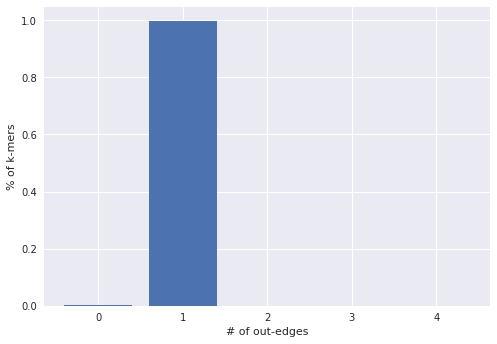

In [34]:
x = list(out_edge_count_frequencies.keys())
y = list(frequency / queried_count for frequency in out_edge_count_frequencies.values())
plt.bar(x, y)
plt.xlabel('# of out-edges')
plt.ylabel('% of queried k-mers')
plt.show()

# W variation analysis

In [50]:
K = 31
D = 8
T = 40

In [37]:
results = []
for W in Ws:
    result = {
        'W': W,
        'queried_count': 0,
        'found_count': 0,
        'false_positive_count': 0,
        'false_positive_count_considering_rc': 0,
    }
    with open(f'K{K}W{W}D{D}T{T}.results') as results_file:
        for line in results_file:
            kmer, query_results = line.strip().split(': ')
            count, out_edges = query_results.strip().split(' ')
            count = int(count)
            out_edges = int(out_edges, 2)

            result['queried_count'] += 1

            if count >= T:
                result['found_count'] += 1

            if count >= T and kmer not in sequence_kmers[K]['forward']:
                result['false_positive_count'] += 1

            if count >= T and (kmer not in sequence_kmers[K]['forward']) and (kmer not in sequence_kmers[K]['reverse_complement']):
                result['false_positive_count_considering_rc'] += 1
        results.append(result)
    
results_df = pd.DataFrame(results)

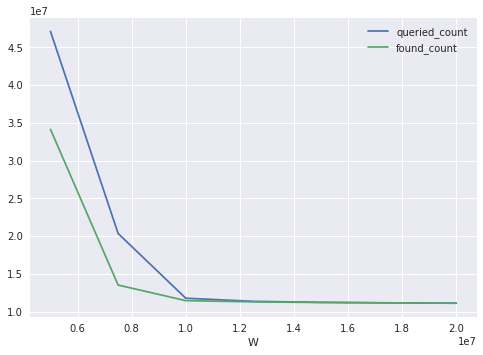

In [43]:
results_df.sort_values('W').plot('W', ['queried_count', 'found_count'])
plt.show()

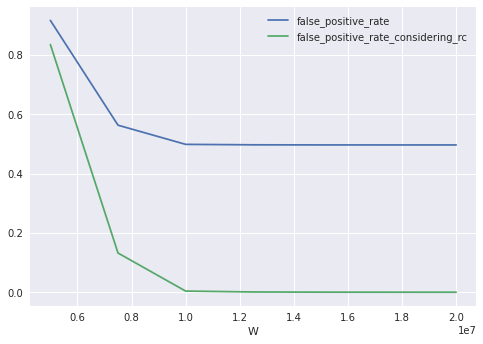

In [49]:
results_df['false_positive_rate'] = results_df['false_positive_count'] / results_df['found_count']
results_df['false_positive_rate_considering_rc'] = results_df['false_positive_count_considering_rc'] / results_df['found_count']
results_df.sort_values('W').plot('W', ['false_positive_rate', 'false_positive_rate_considering_rc'])
plt.show()